In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt
from sklearn.manifold import TSNE

from general_tools.in_out.basics import unpickle_data
from general_tools.in_out import create_dir
from general_tools.notebook.tf import reset_tf_graph

from general_tools.clustering.plt import plot_2d_embedding_in_grid_greedy_way, \
                                         plot_2d_embedding_in_grid_forceful

from general_tools.plotting import stack_images_horizontally

from geo_tool import Point_Cloud

import tf_lab.point_clouds.in_out as pio

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params, pc_sampler, pc_loader
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import pairwise_distances
import random

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [13]:
def incremental_farthest_search(all_dists, k, exluded_points=None, seed=None):
    remaining_points = np.arange(all_dists.shape[0])

    if exluded_points is not None:
        remaining_points = np.setdiff1d(remaining_points, exluded_points)
    
    if seed is not None:
        np.random.seed(seed)
        
    solution_set = [np.random.choice(remaining_points, 1)[0]]    
    remaining_points = np.setdiff1d(remaining_points, solution_set, assume_unique=True)
    
    for _ in range(k-1):
        max_dist = -1
        next_point = -1
        min_distances = []
        for p in remaining_points:
            min_d = np.min(all_pdists[p, solution_set])
            if min_d > max_dist:
                max_dist = min_d
                next_point = p            

        solution_set.append(next_point)
        remaining_points = np.setdiff1d(remaining_points, solution_set, assume_unique=True)
    
    assert(len(np.unique(solution_set)) == k)
    assert(len(np.intersect1d(remaining_points, np.array(solution_set))) == 0)
    
    return solution_set

def evaluate_solution(solution_set):
    distance = lambda a,b: np.linalg.norm(np.array(a)-np.array(b)) 
    return sum([distance(a, b) for a, b in zip(solution_set[:-1], solution_set[1:])])

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
top_data_dir = top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

In [5]:
# load AE model
class_name = 'chair'
syn_id = shape_net_category_to_synth_id()[class_name]
ae_loss = 'emd'
ae_id = '12' # 128 bottleneck

ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)

saved_epochs = read_saved_epochs(ae_conf.train_dir)
load_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [6]:
# Load Raw Point-Clouds of class
n_pc_samples = 2048
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [7]:
pcloud_data = PointCloudDataSet(pclouds, labels=model_ids, init_shuffle=False)
_, latent_codes, temp_names = latent_embedding_of_entire_dataset(pcloud_data, ae, ae_conf)
assert(np.alltrue(temp_names==model_ids))

In [8]:
top_image_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/'
top_image_dir = osp.join(top_image_dir, syn_id)
image_view_tag = 'image_p020_t337_r005.png'

In [11]:
top_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/3d_neighbs_as_context/testing_triplets'
top_out_dir = osp.join(top_out_dir, 'outlier_frac_' + str(int(outlier_fraction * 100)))

In [15]:
all_pdists = pairwise_distances(latent_codes)

In [16]:
random_seed = 42
fps_sol = incremental_farthest_search(all_pdists, 100, outliers, random_seed)

In [17]:
print latent_codes[fps_sol].shape
print evaluate_solution(latent_codes[fps_sol])

(100, 128)
226.832478166


In [23]:
# Find TSNE of sub-selected objects.
seed = 42
model = TSNE(n_components=2, random_state=seed, init='pca')
tsne_coords = model.fit_transform(latent_codes[fps_sol])

# Make a list with the file-names of all to be used images.
image_files = []
for i in fps_sol:
    image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))

save_file = osp.join(top_out_dir, 'tsne_fps_100_examples.png')
plot_2d_embedding_in_grid_forceful(tsne_coords, image_files, big_dim=4000, small_dim=400, save_file=save_file);

In [91]:
def find_first_distant_enough(dists, dist_thres=0.01):
    for i, d in enumerate(dists):
        if d > dist_thres:
            return i
    return -1


def make_triplets(sources, all_pdists, excluded, rule='closest_nn'):
    n = all_pdists.shape[0]
    triplets = []
    for i, s in enumerate(sources):
        candidates = np.arange(n)
        candidates = np.setdiff1d(candidates, excluded)
        candidates = np.setdiff1d(candidates, s)
        
        aso = np.argsort(all_pdists[s, candidates])                        
#         n0 = find_first_distant_enough(all_pdists[s, candidates][aso])
#         print n0
        aso = candidates[aso]
        print aso[0], aso[1], aso[2], aso[3]
#         n0 = 0
        
        if 'closest_nn':
            n0 = 0
            while True:
                if all_pdists[s, aso[n0]] < 1:
                    n0 += 1
                else:
                    print n0
                    break
                    
                             
            triplets.append([s, aso[n0], aso[n0+1]])
            print all_pdists[s, aso[n0]], all_pdists[s, aso[n0+1]]
            
        elif 'one_far':
            far_p = int(np.round(len(aso) * 0.9))
            triplets.append([s, aso[n0], aso[far_p]])
        elif 'both_far':
            far_p1 = int(np.round(len(aso) * 0.9))
            far_p2 = int(np.round(len(aso) * 0.6))
            triplets.append([s, aso[far_p1], aso[far_p2]])
        else:
            assert(False)
                
    return triplets


def plot_triplets(triplets, top_image_dir, top_out_dir, model_ids):
    image_view_tag = 'image_p020_t337_r005.png'
    for i, t in enumerate(triplets):
        image_files = []
        image_files.append(osp.join(top_image_dir, model_ids[t[0]], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[t[1]], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[t[2]], image_view_tag))
        save_file = osp.join(top_out_dir, str(i) + '.png')
        stack_images_horizontally(image_files, save_file=save_file)

5831 1330 6027 2562
0
1.08023 1.12402
[3889, 5831, 1330]


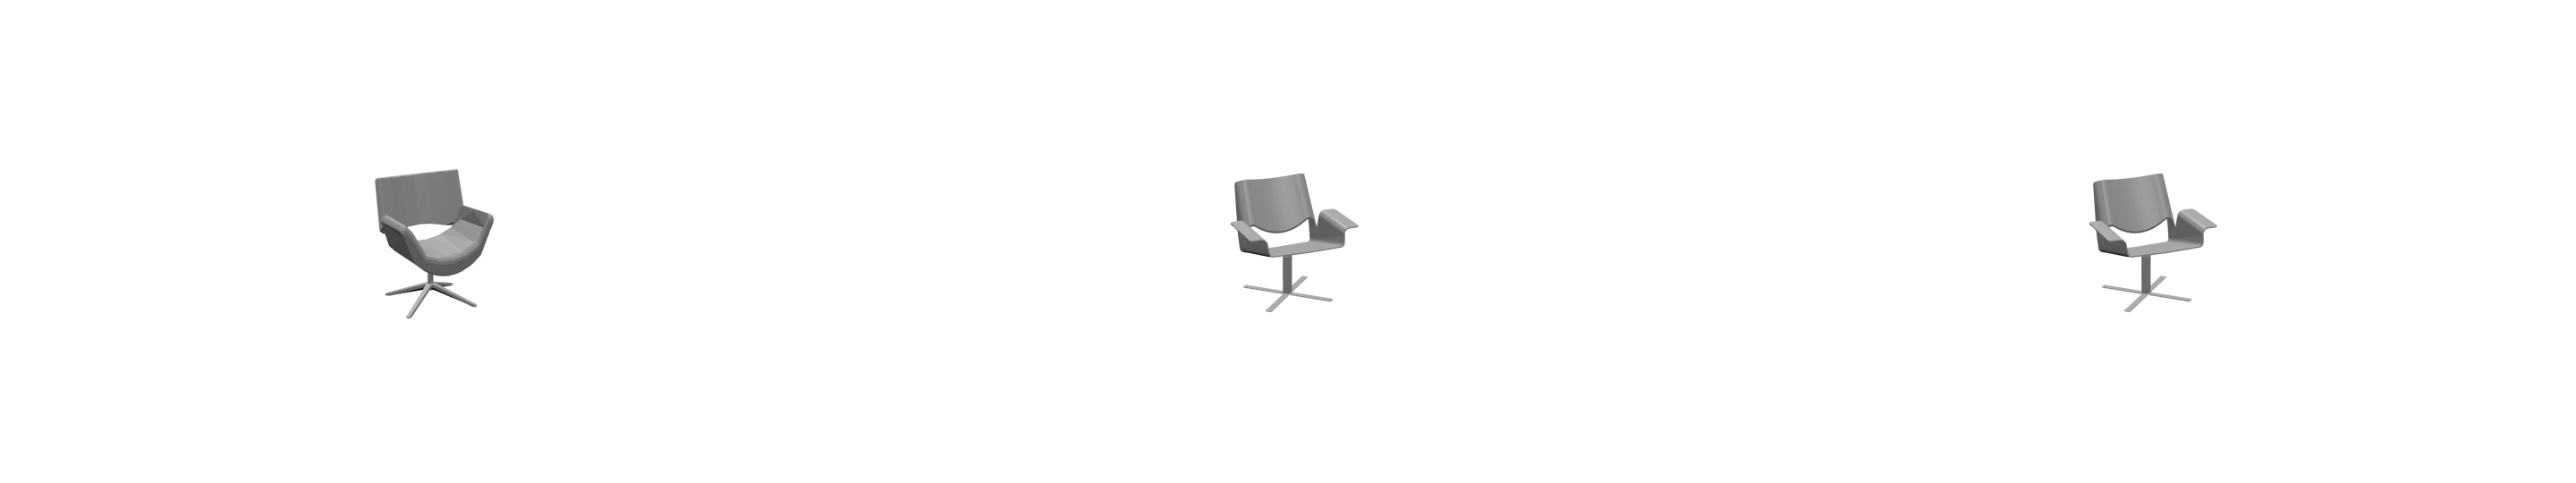

In [101]:
t = make_triplets([fps_sol[17]], all_pdists, outliers, rule)[0]
print t
# make
# n = all_pdists.shape[0] 
# excluded = outliers
# s = fps_sol[13]

# candidates = np.arange(n)
# candidates = np.setdiff1d(candidates, excluded)
# candidates = np.setdiff1d(candidates, s)
# aso = np.argsort(all_pdists[s, candidates])
# aso = candidates[aso]
# t = [s, aso[0], aso[1]]
image_files = []
image_files.append(osp.join(top_image_dir, model_ids[t[0]], image_view_tag))
image_files.append(osp.join(top_image_dir, model_ids[t[1]], image_view_tag))
image_files.append(osp.join(top_image_dir, model_ids[t[2]], image_view_tag))
stack_images_horizontally(image_files)


In [107]:
5831 in outliers

False

In [33]:
rule = 'closest_nn'
triplet_out_dir = create_dir(osp.join(top_out_dir, rule))
triplets = make_triplets(fps_sol, all_pdists, outliers, rule)
plot_triplets(triplets, top_image_dir, triplet_out_dir, model_ids)

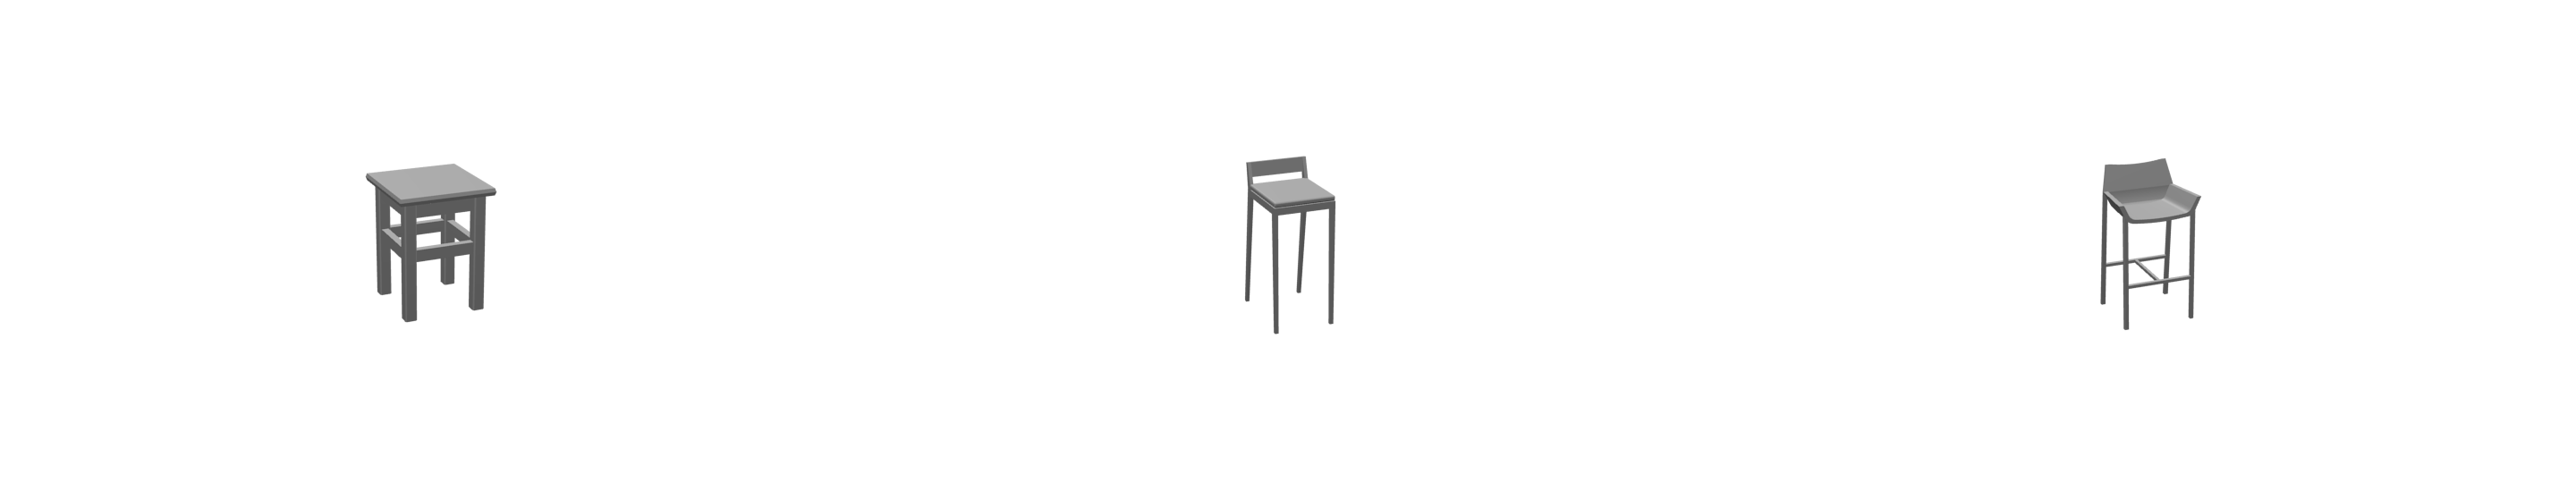

In [29]:
check = fps_sol[1]
lala = np.argsort(all_pdists[check, :])

image_files = []
image_files.append(osp.join(top_image_dir, model_ids[check], image_view_tag))
image_files.append(osp.join(top_image_dir, model_ids[lala[5]], image_view_tag))
image_files.append(osp.join(top_image_dir, model_ids[lala[8]], image_view_tag))

stack_images_horizontally(image_files)